In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

In [2]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

In [3]:
#prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

In [4]:
#Alice's operation 
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

In [5]:
#Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

In [6]:
#Bob use the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit0)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

protocol.draw()


░      ┌───┐ ░    ┌─┐ ░                                     »
  Q: ───────────░───■──┤ H ├─░────┤M├─░─────────────────────────────────────»
     ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░ ┌────── ┌───┐ ───────┐              »
  A: ┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─┤ If-0  ┤ X ├  End-0 ├──────────────»
     └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ └──╥─── └───┘ ───────┘ ┌────── ┌───┐»
  B: ─────┤ X ├─░────────────░──╫──╫──░────╫───────────────────┤ If-0  ┤ Z ├»
          └───┘ ░            ░  ║  ║  ░ ┌──╨──┐                └──╥─── └───┘»
a: 1/═══════════════════════════╩══╬════╡ 0x1 ╞═══════════════════╬═════════»
                                0  ║    └─────┘                ┌──╨──┐      »
b: 1/══════════════════════════════╩═══════════════════════════╡ 0x1 ╞══════»
                                   0                           └─────┘      »
«               
«  Q: ──────────
«               
«  A: ──────────
«      ───────┐ 
«  B:   End-0 ├─
«      ───────┘ 
«a: 1/══════════
«               
«b: 1/══════════
«

In [7]:
# Create a new circuit including the same bits and qubits used in the teleportation protocol, along with a new "auxiliary" qubit R
aux = QuantumRegister(1, "R")
test = QuantumCircuit(aux, qubit, ebit0, ebit1, a, b)


In [8]:
#Entangle Q with R 
test.h(aux) 
test.cx(aux, qubit)
test.barrier()


In [9]:
#Append the protocol the circuit. The 'qubit' argument tells Qiskit that the protocol should operate on the qubits 
#numberd 1,2, and 3 (skipping qubit 0, which is R). 
test = test.compose(protocol, qubits=[1,2,3])
test.barrier()

In [10]:
#After the protocols runs, check that (B,R) is in a phi+ state. We can add a new classical bit to the circuit to do this
test.cx(aux, ebit1)
test.h(aux)
result = ClassicalRegister(1, "Test result1")
test.add_register(result)
test.measure(aux, result)

test.draw()

┌───┐      ░                                                »
           R: ┤ H ├──■───░────────────────────────────────────────────────»
              └───┘┌─┴─┐ ░            ░      ┌───┐ ░    ┌─┐ ░             »
           Q: ─────┤ X ├─░────────────░───■──┤ H ├─░────┤M├─░─────────────»
                   └───┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ ┌─┐└╥┘ ░ ┌──────────┐»
           A: ───────────░─┤ H ├──■───░─┤ X ├──────░─┤M├─╫──░─┤0         ├»
                         ░ └───┘┌─┴─┐ ░ └───┘      ░ └╥┘ ║  ░ │          │»
           B: ───────────░──────┤ X ├─░────────────░──╫──╫──░─┤  If_else ├»
                         ░      └───┘ ░            ░  ║  ║  ░ │          │»
           a: ════════════════════════════════════════╩══╬════╡0         ╞»
                                                         ║    └──────────┘»
           b: ═══════════════════════════════════════════╩════════════════»
                                                                          »
Test result1: ════════════════════════════════════════════════════════════»
                                                                          »
«                           ░      ┌───┐┌─┐
«           R: ─────────────░───■──┤ H ├┤M├
«                           ░   │  └───┘└╥┘
«           Q: ─────────────░───┼────────╫─
«                           ░   │        ║ 
«           A: ─────────────░───┼────────╫─
«              ┌──────────┐ ░ ┌─┴─┐      ║ 
«           B: ┤0         ├─░─┤ X ├──────╫─
«              │          │ ░ └───┘      ║ 
«           a: ╡          ╞══════════════╬═
«              │          │              ║ 
«           b: ╡0         ╞══════════════╬═
«              └──────────┘              ║ 
«Test result1: ══════════════════════════╩═
«

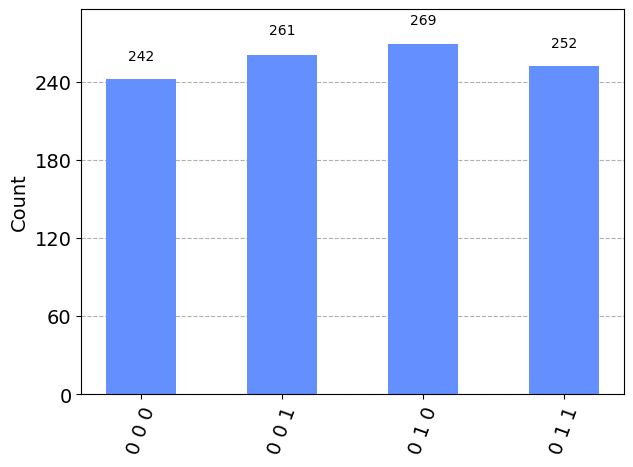

In [14]:
#run the Aer simulator on this circuit and plot a histogram of the output
counts = AerSimulator().run(test).result().get_counts()
plot_histogram(counts)

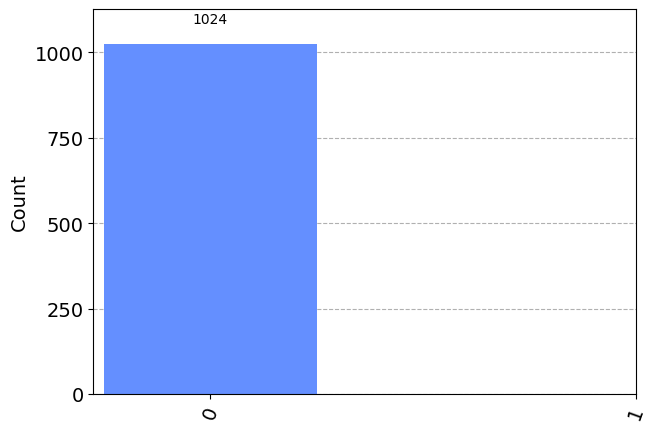

In [16]:
#only focus on counted qubit
filtered_counts = {"0": 0, "1": 0}
for result, frequency in counts.items():
    filtered_counts[result[0] ]+= frequency
plot_histogram(filtered_counts)